In [85]:
import wignax as wx
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

# Jaynes-Cummings Model

In [86]:
# 1. Physical Parameters
g = 1.0   
t_eval = jnp.linspace(0, 5.0, 1000)
N_samples = 100_000

In [87]:
# 2. Define the Hamiltonian in the interaction picture
#    in terms of separate variables
def H_jcm_split(t, alpha, S, args):
    g = args['g']
    
    x = jnp.real(alpha)
    y = jnp.imag(alpha)
    Sx, Sy, Sz = S[..., 0], S[..., 1], S[..., 2]
    
    return g * (x * Sx - y * Sy)

In [88]:
# 2. Instantiate Generators of EOM
boson_gen = wx.generating_eom_bosons(lambda t, a, args: H_jcm_split(t, a, args['S'], args))
spin_gen  = wx.generating_eom_spins(lambda t, s, args: H_jcm_split(t, args['alpha'], s, args))

In [89]:
# 3. Create the Combined Drift
def jcm_drift(t, state_flat, args):
    # state_flat is (..., 5) [Re, Im, Sx, Sy, Sz]
    
    # Reconstruct Boson
    alpha = state_flat[..., 0] + 1j * state_flat[..., 1]
    # Reconstruct Spin
    S = state_flat[..., 2:5]
    
    # Add context to args so generators can see the "other" variable
    # This is a standard trick for coupled systems
    args_with_state = args.copy()
    args_with_state['alpha'] = alpha
    args_with_state['S'] = S
    
    # A. Get Boson Drift (Automatic Real-Symplectic)
    d_alpha = boson_gen(t, alpha, args_with_state)

    # B. Get Spin Drift (Automatic Pauli-Commutator)
    d_S = spin_gen(t, S, args_with_state)
    
    # Repack
    return jnp.concatenate([
        jnp.stack([d_alpha.real, d_alpha.imag], axis=-1),
        d_S
    ], axis=-1)

In [90]:
# 4. Generate the initial state
key = jax.random.PRNGKey(42)
k_cav, k_spin = jax.random.split(key)

# Cavity: Coherent State |alpha=4> (N=16)
alpha0 = 4.0
cav_samples_c = wx.sample_coherent(k_cav, N_samples, 1, alpha0)
cav_samples = jnp.concatenate([cav_samples_c.real, cav_samples_c.imag], axis=1) # dim -> (N, 2)

# Spin: Ground State |Down> (Sz = -1 for Pauli)
spin_samples = wx.sample_spin_discrete(k_spin, N_samples, 1, initial_z=-1.0)
spin_samples = spin_samples.squeeze(axis=1) # dim -> (N, 3)

# Combine -> (N, 5)
hybrid_samples = jnp.concatenate([cav_samples, spin_samples], axis=1)
state = wx.PhaseSpaceState(hybrid_samples)

In [91]:
# 5. Solve the dynamics
simulation_args = {'g': g}

mean_traj, var_traj = wx.solve(
    jcm_drift, 
    state, 
    t_eval, 
    args=simulation_args,  
    batch_size = int(N_samples/2)  # Adjust based on GPU memory
)

Wignax Simulation: 100000 trajectories (Direct Complex Mode)


Simulating:   0%|          | 0/2 [00:00<?, ?it/s]

In [92]:
# 6. Extract the results

# Extract Means
x_mean, y_mean = mean_traj[:, 0], mean_traj[:, 1]
sz_mean = mean_traj[:, 4]
prob_exc = 0.5 * (sz_mean + 1)

# Reconstruct Photon Number
# <n> = <|alpha|^2> - 0.5
mean_sq_x = var_traj[:, 0] + x_mean**2
mean_sq_y = var_traj[:, 1] + y_mean**2
n_photons = (mean_sq_x + mean_sq_y) - 0.5

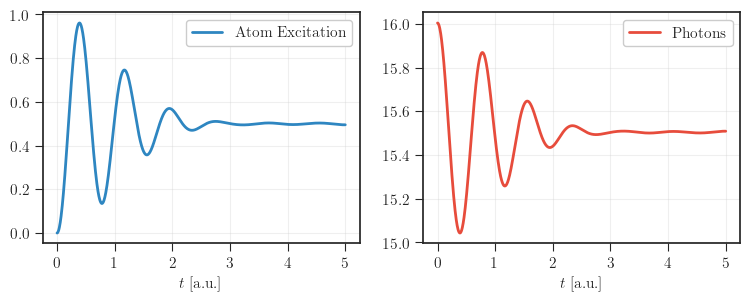

In [93]:
plt.style.use(['seaborn-v0_8-white', './style.mplstyle'])

fig, ax = plt.subplots(1, 2, figsize=(9, 3))

ax[0].plot(t_eval, prob_exc, label = 'Atom Excitation',
            linewidth = 2, color = '#2E86C1')
ax[0].grid(alpha = 0.3)
ax[0].legend()
ax[0].set_xlabel(r"$t$ [a.u.]")
ax

ax[1].plot(t_eval, n_photons, label = 'Photons',
           linewidth = 2, color = '#E74C3C')
ax[1].grid(alpha = 0.3)
ax[1].legend()
ax[1].set_xlabel(r"$t$ [a.u.]")

plt.show()